In [76]:
import os
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pydicom

from skimage.measure import regionprops, label
from skimage.segmentation import mark_boundaries

from tqdm import tqdm_notebook

In [77]:
# Get directory names/locations
data_root = os.path.abspath("../input/rsna-intracranial-hemorrhage-detection/")

train_img_root = data_root + "/stage_1_train_images/"
test_img_root  = data_root + "/stage_1_test_images/"

train_labels_path = data_root + "/stage_1_train.csv"
test_labels_path  = data_root + "/stage_1_test.csv"

# Create list of paths to actual training data
train_img_paths = os.listdir(train_img_root)
test_img_paths  = os.listdir(test_img_root)

# Dataset size
num_train = len(train_img_paths)
num_test  = len(test_img_paths)

In [78]:
def create_efficient_df(data_path):
    
    # Define the datatypes we're going to use
    final_types = {
        "ID": "str",
        "Label": "float16"
    }
    features = list(final_types.keys())
    
    # Use chunks to import the data so that less efficient machines can only use a 
    # specific amount of chunks on import
    df_list = []

    chunksize = 1_000_000

    for df_chunk in pd.read_csv(data_path, dtype=final_types, chunksize=chunksize): 
        df_list.append(df_chunk)
        
    df = pd.concat(df_list)
    df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

    del df_list

    return df

train_labels_df = create_efficient_df(train_labels_path)
train_labels_df[train_labels_df["Label"] > 0].head()

,ID,Label
88,ID_aeda0804d_subdural,1.0
89,ID_aeda0804d_any,1.0
219,ID_5fc337950_subarachnoid,1.0
221,ID_5fc337950_any,1.0
265,ID_4f4c47ae0_intraparenchymal,1.0


In [79]:
hem_types = [
    "epidural",
    "intraparenchymal",
    "intraventricular",
    "subarachnoid",
    "subdural",
    "any"
]

new_cols = [
    "id",
    "type_0",
    "type_1",
    "type_2",
    "type_3",
    "type_4",
    "type_5"
]

num_ids = int(train_labels_df.shape[0] / len(hem_types))
print("Number of unique patient IDs: {}".format(num_ids))

empty_array = np.ones((num_ids, len(new_cols)))
hem_df = pd.DataFrame(data=empty_array, columns=new_cols)

# Fill in the ID of each image
hem_df["id"] = list(train_labels_df.iloc[::len(hem_types)]["ID"].str.split(pat="_").str[1])
    
# Fill in the categorical columns of each image
for hem_ix, hem_col in enumerate(list(hem_df)[1:]):
    hem_df[hem_col] = list(train_labels_df.iloc[hem_ix::len(hem_types), 1])
    
hem_df.info()
hem_df[hem_df["type_5"] > 0].head()

Number of unique patient IDs: 674262
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 674262 entries, 0 to 674261
Data columns (total 7 columns):
id        674262 non-null object
type_0    674262 non-null float64
type_1    674262 non-null float64
type_2    674262 non-null float64
type_3    674262 non-null float64
type_4    674262 non-null float64
type_5    674262 non-null float64
dtypes: float64(6), object(1)
memory usage: 36.0+ MB


,id,type_0,type_1,type_2,type_3,type_4,type_5
14,aeda0804d,0.0,0.0,0.0,0.0,1.0,1.0
36,5fc337950,0.0,0.0,0.0,1.0,0.0,1.0
44,4f4c47ae0,0.0,1.0,1.0,0.0,0.0,1.0
66,fb4205b7f,0.0,0.0,0.0,1.0,1.0,1.0
69,789fcc41a,0.0,0.0,0.0,0.0,1.0,1.0


# Introduction

Hello, my name is Mick. I've written a couple of other notebooks for this competition but today I'm going to actually dive into some image analysis. This notebook is meant to be a demonstration of some image analysis techniques and as such will mostly be operating on only one or two images, rather than creating a pipeline that analyzes many images in a rapid manner. The main techniques I'll be focusing on will revolve around the Sci-Kit Image library and use segmentation methods to split the images into their component parts. Our goal will be something like pulling out all of the regions that are likely to contain hemorrhages within an individual CT scan. 

If you want an introduction to the [file format these images come in](https://www.kaggle.com/smit2300/dicom-patient-analysis), [some anatomical background on hemorrhages](https://www.kaggle.com/smit2300/hemorrhage-medical-introduction), or otherwise [information on exploring this dataset](https://www.kaggle.com/smit2300/hemorrhage-eda-encoding-dicom-introduction), you can check out any of my other notebooks in this competition to get a feel for the RSNA's Intracranial Hemorrhage dataset. 

Now that we're settled, lets start doing some image analysis!

# Image Viewing

The first thing I'll do is simply pick out and image that we can segment and try to find some interesting features of the image.

In [80]:
CERTAINTY = 0.95

# Filter the dataframe to search for epidural hemorrhages
epi_df = hem_df[(hem_df["type_0"] > CERTAINTY) & (hem_df["type_1"] < CERTAINTY) & (hem_df["type_2"] < CERTAINTY) & (hem_df["type_3"] < CERTAINTY) & (hem_df["type_4"] < CERTAINTY)]

# Custom indices of images that contain good looking hemorrhages to me (please suggest better image if anyone know of any!)
epi_ix = 6

# Slice out the record at the chosen index
epi_record = epi_df.iloc[epi_ix, :]

# Get the image path from the record
epi_path = train_img_root + "ID_" + epi_record["id"] + ".dcm"

# Use PyDICOM to open the image and get array data
epidural_frame = pydicom.dcmread(epi_path).pixel_array

# Normalize the array between 0 and 255
epidural_frame = np.interp(epidural_frame, (epidural_frame.min(), epidural_frame.max()), (0, 255))

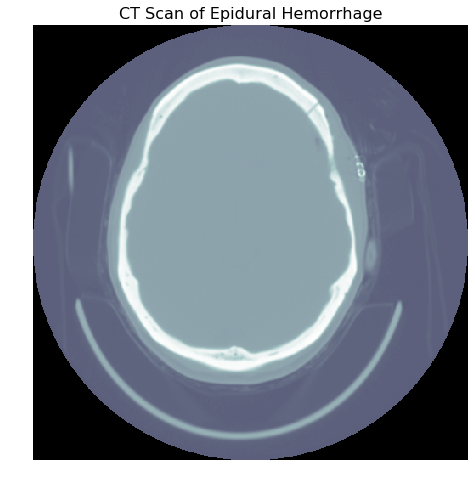

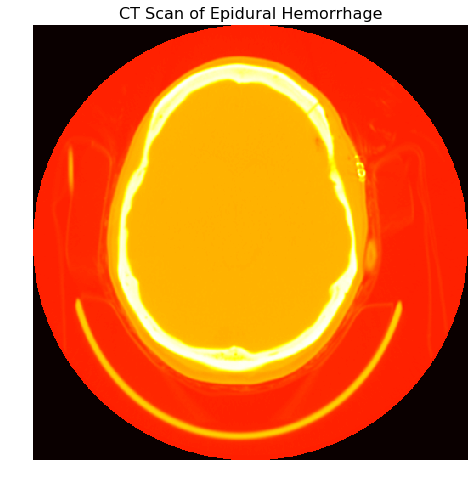

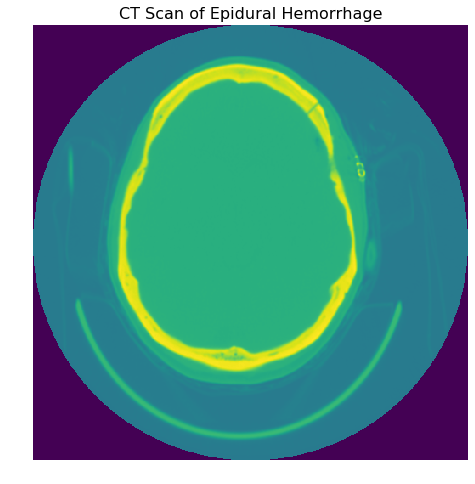

In [81]:
def plot_frame(img_array, cmap, title):
    plt.figure(figsize=(8,8))
    plt.imshow(img_array, cmap=cmap)
    plt.title(title, fontsize=16)
    plt.axis("off")
    
plot_frame(epidural_frame, "bone", "CT Scan of Epidural Hemorrhage")
plot_frame(epidural_frame, "hot", "CT Scan of Epidural Hemorrhage")
plot_frame(epidural_frame, "viridis", "CT Scan of Epidural Hemorrhage")

# Statistical Brightness Analysis

Alright we've found an example of each type of exclusive hemorrhage. There aren't too many explicit differences between the images and I'm actually not even particularly certain that the images I've chosen are good representations of each type of hemorrhage (If anyone has suggestions for good exemplary images then please feel free to leave a comment)! However, we can see some clear artifacts in these images that I'll show you how to separate out from the image.

The first thing I'll do is check out a histogram for the brightness levesl of each image. We may be able to find regions that are representative of each of the types of hemorrhage and brightness that might indicate hemorrhage type. For the next couple steps I'll show analysis of just an epidural image and then we can expand that to encompass the other hemorrhage types.

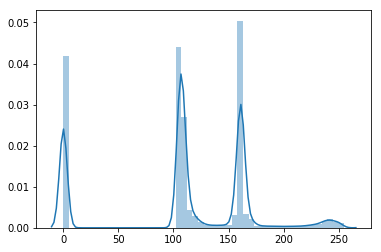

In [82]:
sns.distplot(epidural_frame.flatten())

We can see some clear peaks on this histogram for image brightness. The regions I'm going to focus on are those of high density. Since we're going to mostly be looking for hemorrhages in this dataset we want to analyze the regions of the image that correspond to the skull and any perturbations it might be seeing.

# Image Masking

Now that we know the distribution of brightness within the image we can create some masks that capture specific regions of this histogram. This is a fairly primitive method to segment an image and many algorithms exist for adaptively filtering the image, but for explanatory purposes I'll just be using a hard threshold of ~200 to segment these images.

Let's view the image, the binary mask that is created from thresholding, and the result of multiplying the original image with the mask.

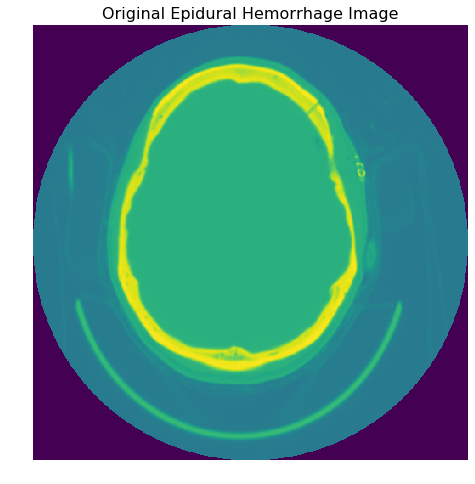

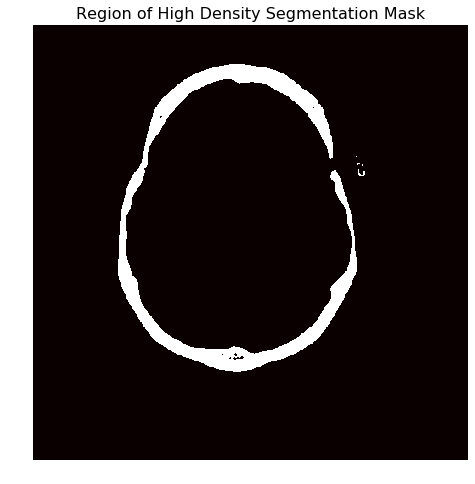

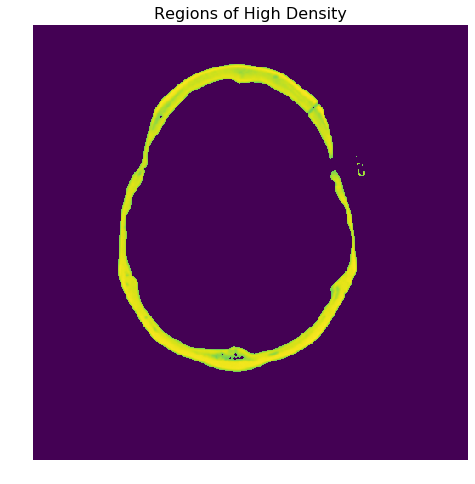

In [83]:
dense_mask   = (epidural_frame > 200).astype(int)
dense_frame  = (epidural_frame * dense_mask).astype(int)
dense_coords = np.argwhere(dense_frame)

plot_frame(epidural_frame, "viridis", "Original Epidural Hemorrhage Image")
plot_frame(dense_mask, "hot", "Region of High Density Segmentation Mask")
plot_frame(dense_frame, "viridis", "Regions of High Density")

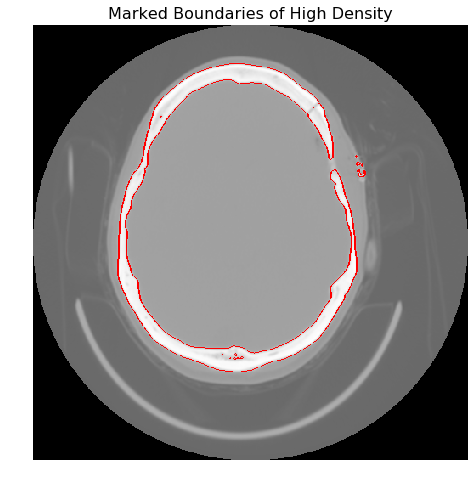

In [84]:
norm_frame = epidural_frame / 255.0
segmented_frame = mark_boundaries(norm_frame, dense_mask, color=(255,0,0))

plot_frame(segmented_frame, "bone", "Marked Boundaries of High Density")

Awesome! We can see our image clearly segmented to specifically highlight regions of the highest density on the CT scan. This methodology has been used in slightly augmented forms for years and is sometimes used to create datasets for deep learning. 

The image that we've chosen seems to have a small artifact on what I believe is the anterior right side of the patient's skull. There is also a discontinuity in density that wasn't immediately clear in the original scan images. It's possible that we've found an anomalous region of the image that could be the result of injury and thus a hemorrhage. For later notebooks I'll try to analyze regions of specific injury and other stops along the way for deep learning models, but for this notebook the last thing I want to show is the Scikit-Image `regionprops()` method.

# regionprops()

The regionprops() method may be familiar if you come from a MATLAB background. The method employs an algorithm that finds all regions within an image that meet a set of labelled criteria provided by the programmer. We've created that criteria by making our boolean mask earlier. In order to pass the labelling image to the `regionprops()` method we first have to turn it into a Scikit-Image safe labelling array using the `label()` method. 

Once we've used the `regionprops()` method to split the image into specific regions we can iterate over those and print out information on all of the continuous regions found within the image. This is a useful process for things like computing area of shapes or performing morphological calculations on regions within an image.

In [85]:
label_img = label(dense_mask)
regions   = regionprops(label_image=label_img, intensity_image=dense_frame)

largest_area = max([regions[x].area for x in range(len(regions))])
print("Largest high density area: {}".format(largest_area))

num_bones = len(regions)
print("Number of high density regions: {}".format(num_bones))

for prop_ix, props in enumerate(regions):
    print("\nHotspot number {}:".format(prop_ix+1))
    print("Area: %d" % (props.area))
    print("Centroid: (%.2f, %.2f)" % (props.centroid[0],props.centroid[1]))
    print("Mean Intensity: %.2f" % (props.mean_intensity))
    print("Max Intensity: %d" % (props.max_intensity))
    

Largest high density area: 13519
Number of high density regions: 5

Hotspot number 1:
Area: 13519
Centroid: (230.51, 236.15)
Mean Intensity: 234.89
Max Intensity: 255

Hotspot number 2:
Area: 1
Centroid: (154.00, 380.00)
Mean Intensity: 200.00
Max Intensity: 200

Hotspot number 3:
Area: 9
Centroid: (162.89, 382.11)
Mean Intensity: 216.89
Max Intensity: 234

Hotspot number 4:
Area: 2
Centroid: (164.50, 387.00)
Mean Intensity: 202.50
Max Intensity: 203

Hotspot number 5:
Area: 30
Centroid: (174.40, 385.97)
Mean Intensity: 215.10
Max Intensity: 237


# Conclusion

This has been a basic introduction to get started with basic image segmentation using Scikit-Image. If there are any methods that people would like to see in this notebook please feel free to leave a comment and I would be happy to include them in the notebook or learn about them if they're not something I'm already familiar with.

I hope you enjoyed and maybe even learned a little from this notebook! I'll see you in next one.